In [1]:
#from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
#import shutil
#import posixpath
import datetime
import wfdb

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Using TensorFlow backend.


In [2]:
record = wfdb.rdrecord('mitdb/100')
annotation = wfdb.rdann('mitdb/100', 'atr')
display(record.__dict__)
display(annotation.__dict__)

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

{'record_name': '100',
 'extension': 'atr',
 'sample': array([    18,     77,    370, ..., 649484, 649734, 649991]),
 'symbol': ['+',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'A',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'

In [3]:
# All relevant symbols for this research.
relsym = set("NLRejV!EAaSJF/fQ")

def to_aami(ba):
    if ba in set("NLRej"):
        return "Normal"
    if ba in set("V!E"):
        return "Ventricular"
    if ba in set("AaSJ"):
        return "Supraventricular"
    if ba == "F":
        return "Fusion beat"
    if ba in set("/fQ"):
        return "Unknown beats"
    else: 
        return "This should not be happening."

def to_aami_num(aami):
    d = {"Normal" : 0,
        "Ventricular" : 1,
        "Supraventricular" : 2,
        "Fusion beat" : 3,
        "Unknown beats" : 4}
    return d[aami]

    
class Beat:
    def __init__(self, ba, patient):
        self.ba = ba
        self.aami = to_aami(ba)
        self.aami_num = to_aami_num(self.aami)
        self.patient = patient


beats = []
window = int(1.8*360)
scaler = MinMaxScaler()

def format_signal(signal, mid, w=window):
    left, right = [], []
    start = mid - w
    if start >= 0:
        left = signal[start:mid]
    else:
        left = [signal[0]] * (start * -1)
        left.extend(signal[:mid])
    right = signal[mid:mid+w]
    if len(right) != w:
        n = [signal[-1]] * (w - len(right))
        right.extend(n)
    left.extend(right)
    assert len(left) == w*2
    return left


def reshape_signal(signal):
    s = np.array([[float(i)] for i in signal])
    s = scaler.fit_transform(s)
    s = np.array([[int(i*255)]*3 for i in s])
    return s.reshape(36,36,3)

In [4]:
for file in os.listdir("mitdb"):
    if file.endswith(".atr"):
        record = wfdb.rdrecord("mitdb/"+file.split(".")[0])
        ann = wfdb.rdann("mitdb/"+record.record_name, 'atr')
        end = 0
        for i in range(ann.ann_len - 1):
            ba = ann.symbol[i]
            if ba in relsym:
                beat = Beat(ba, record.record_name)
                beat.start = end
                end = int((ann.sample[i] + ann.sample[i+1]) / 2)
                beat.end = end
                signal = [t[0] for t in record.p_signal[beat.start:beat.end]]
                beat.signal = format_signal(signal, ann.sample[i] - beat.start)
                beat.mid = ann.sample[i] - beat.start
                beat.data = reshape_signal(beat.signal)
                beats.append(beat)

1296


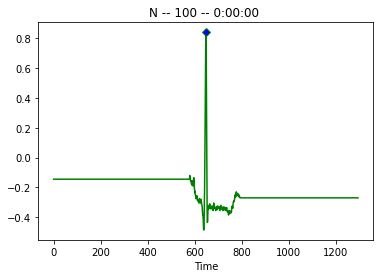

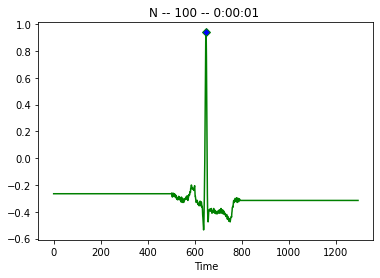

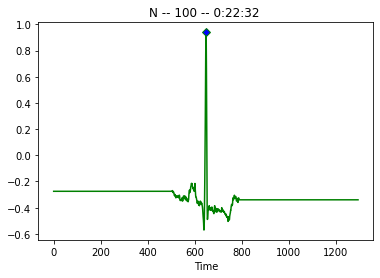

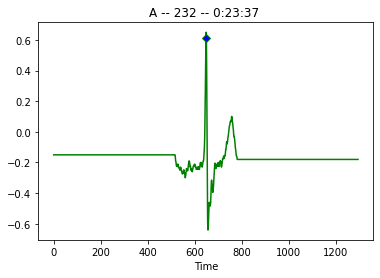

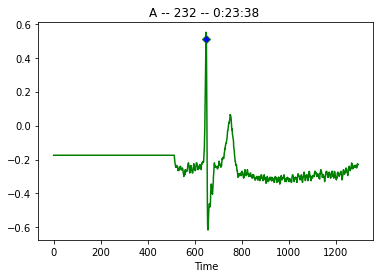

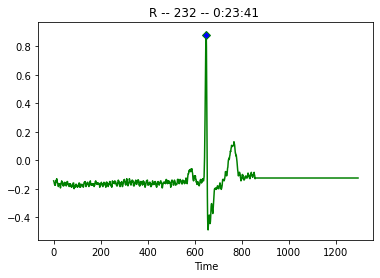

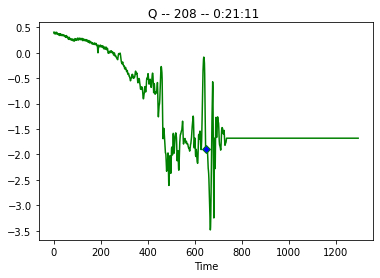

In [5]:
def get_timestamp(i):
    return datetime.timedelta(seconds=round(i/360))

def print_beat(beat):
    fig, ax = plt.subplots()
    plt.title("{} -- {} -- {} ".format(beat.ba, beat.patient, get_timestamp(beat.start)))

    plt.locator_params(axis='y')
    ax.plot(beat.signal, '-gD', markevery=[window], mfc = 'b')
    ax.set_xlabel('Time')

print_beat(beats[0])
print_beat(beats[1])
print_beat(beats[1701])
print_beat(beats[99295])
print_beat(beats[99296])
print_beat(beats[99297])
print_beat(beats[59976])

print(len(beats[0].signal))

In [6]:
scaler = MinMaxScaler()
l = list(range(12))
e = l
l = np.array([[float(i)] for i in l])
print(l)


sl = scaler.fit_transform(l)
print(sl)

m = sl.reshape(3,4)
print(m)

e = np.array([np.asarray([i,i,i]) for i in e])
print(e.shape)
e = e.reshape(4, 3, 3)
print(e)

[[ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]
 [ 7.]
 [ 8.]
 [ 9.]
 [10.]
 [11.]]
[[0.        ]
 [0.09090909]
 [0.18181818]
 [0.27272727]
 [0.36363636]
 [0.45454545]
 [0.54545455]
 [0.63636364]
 [0.72727273]
 [0.81818182]
 [0.90909091]
 [1.        ]]
[[0.         0.09090909 0.18181818 0.27272727]
 [0.36363636 0.45454545 0.54545455 0.63636364]
 [0.72727273 0.81818182 0.90909091 1.        ]]
(12, 3)
[[[ 0  0  0]
  [ 1  1  1]
  [ 2  2  2]]

 [[ 3  3  3]
  [ 4  4  4]
  [ 5  5  5]]

 [[ 6  6  6]
  [ 7  7  7]
  [ 8  8  8]]

 [[ 9  9  9]
  [10 10 10]
  [11 11 11]]]


# Keras part

In [6]:
model = Sequential([
    Dense(units=720, input_dim=720, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=5, activation='softmax')
])
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

signals, labels = [], []
for b in beats:
    signals.append(b.signal)
    labels.append(b.aami_num)


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 720)               519120    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                46144     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 578,069
Trainable params: 578,069


In [7]:
model.fit(x=np.asarray(signals), y=np.asarray(labels), validation_split=0.2, epochs=100, shuffle=True, verbose=2)

Train on 84403 samples, validate on 21101 samples
Epoch 1/100
 - 27s - loss: 0.1854 - accuracy: 0.9552 - val_loss: 0.4542 - val_accuracy: 0.8821
Epoch 2/100
 - 31s - loss: 0.1159 - accuracy: 0.9706 - val_loss: 0.6005 - val_accuracy: 0.8749
Epoch 3/100
 - 31s - loss: 0.0988 - accuracy: 0.9745 - val_loss: 0.6210 - val_accuracy: 0.8433
Epoch 4/100
 - 30s - loss: 0.0911 - accuracy: 0.9767 - val_loss: 0.7495 - val_accuracy: 0.8778
Epoch 5/100
 - 31s - loss: 0.0832 - accuracy: 0.9779 - val_loss: 0.5090 - val_accuracy: 0.8778
Epoch 6/100
 - 33s - loss: 0.0774 - accuracy: 0.9798 - val_loss: 0.6388 - val_accuracy: 0.8559
Epoch 7/100
 - 30s - loss: 0.0740 - accuracy: 0.9806 - val_loss: 0.6637 - val_accuracy: 0.8711
Epoch 8/100
 - 26s - loss: 0.0700 - accuracy: 0.9815 - val_loss: 0.7407 - val_accuracy: 0.8006
Epoch 9/100
 - 26s - loss: 0.0674 - accuracy: 0.9820 - val_loss: 0.6886 - val_accuracy: 0.8285
Epoch 10/100
 - 27s - loss: 0.0638 - accuracy: 0.9830 - val_loss: 0.5877 - val_accuracy: 0.8811

KeyboardInterrupt: 

In [13]:
x = tf.ones((1,2))

In [14]:
print(x)

Tensor("ones:0", shape=(1, 2), dtype=float32)


In [8]:
mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [75]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(36,36,3,),
    pooling=None,
    classes=1000,
)

x = resnet.output
x = GlobalAveragePooling2D()(x)

x = Dense(100, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=resnet.input, outputs=predictions)

for layer in resnet.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

signals, labels = [], []
for b in beats:
    signals.append(b.data)
    labels.append(b.aami_num)

In [76]:
model.fit(x=np.array(signals), y=np.array(labels), validation_split=0.2, epochs=20, shuffle=True, verbose=2)

Train on 84403 samples, validate on 21101 samples
Epoch 1/20
 - 662s - loss: 0.2010 - acc: 0.9492 - val_loss: 0.9726 - val_acc: 0.7763
Epoch 2/20
 - 662s - loss: 0.1599 - acc: 0.9615 - val_loss: 1.9620 - val_acc: 0.6898
Epoch 3/20


KeyboardInterrupt: 

In [11]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(36,36,3,),
    pooling=None,
    classes=5,
)

for layer in resnet.layers:
    layer.trainable = False
    
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)

model.summary()


model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

signals, labels = [], []
for b in beats:
    signals.append(b.data)
    labels.append(b.aami_num)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 36, 36, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 42, 42, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 18, 18, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 18, 18, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
model.fit(x=np.array(signals), y=np.array(labels), validation_split=0.2, epochs=20, shuffle=True, verbose=2)

Train on 84403 samples, validate on 21101 samples
Epoch 1/20
 - 589s - loss: 0.1937 - acc: 0.9507 - val_loss: 1.0272 - val_acc: 0.7399
Epoch 2/20
 - 608s - loss: 0.1584 - acc: 0.9598 - val_loss: 1.1889 - val_acc: 0.7241
Epoch 3/20


KeyboardInterrupt: 

# MobileNet tests

In [23]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(36,36,3,),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
)

for layer in mobilenet.layers:
    layer.trainable = False
    
x = mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=mobilenet.input, outputs=predictions)

model.summary()


model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

signals, labels = [], []
for b in beats:
    signals.append(b.data)
    labels.append(b.aami_num)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 36, 36, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 37, 37, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 18, 18, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 18, 18, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [ ]:
model.fit(x=np.array(signals), y=np.array(labels), validation_split=0.2, epochs=20, shuffle=True, verbose=2)

Train on 84403 samples, validate on 21101 samples
Epoch 1/20
